## Data Analysis

This notebook will be used to analyse data from Combination Lock experiments.


### Install Libraries


In [43]:
from statsmodels.stats.anova import AnovaRM
import pandas as pd
import matplotlib as mpl
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import glob
import json

%pip install matplotlib
%pip install pandas statsmodels
%matplotlib inline


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Read in Files


In [44]:
log_dir = './docs/evaluation-logs/*'
filepaths = glob.glob(log_dir)

files = []

for path in filepaths:
    with open(path) as f:
        files.append(json.load(f)['data'])


### Extract Data Across Participants into Single Dict


In [45]:
fullDict = {}


for f in files:
    fullDict = fullDict | f

print(len(fullDict))


85


### Traverse entire dataset, adding each list to the appropraite method list


In [46]:
methodsDict = {'tap6': [], 'tap10': [], 'direction6': [],
               'direction10': [], 'pin': [], 'pattern': []}

for key in fullDict.keys():
    method = fullDict[key][0]['method']
    numTicks = fullDict[key][0]['numTicks']

    if method == 'tap':
        if numTicks == '6':
            methodsDict['tap6'] += fullDict[key]
        else:
            methodsDict['tap10'] += fullDict[key]
    elif method == 'direction':
        if numTicks == '6':
            methodsDict['direction6'] += fullDict[key]
        else:
            methodsDict['direction10'] += fullDict[key]
    elif method == 'PATTERN':
        methodsDict['pattern'] += fullDict[key]
    elif method == 'PIN':
        methodsDict['pin'] += fullDict[key]

# Remove Abortions
for key in methodsDict:
    methodsDict[key] = list(
        filter(lambda x: x['endState'] != 'ABORTED', methodsDict[key]))


### Graph Average Success Rate For Each Method


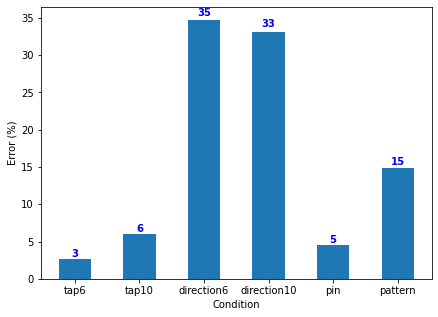

In [47]:
errorRates = {}


def computeErrorRate(lst):
    errors = len(list(filter(lambda x: x['endState'] == 'FAILURE', lst)))
    return (errors / len(lst)) * 100


for method in methodsDict:
    errorRates[method] = computeErrorRate(methodsDict[method])


fig, ax = plt.subplots(figsize=(7, 5))
ax.set_ylabel('Error (%)')
ax.set_xlabel('Condition')

x = list(errorRates.keys())
y = list(errorRates.values())


rects = ax.bar(x, y, 0.5)

for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.01*height, '%d' %
            round(height),  ha='center', va='bottom', color='blue', fontweight='bold')


### Graph Average Authentication Time for Successful Sessions


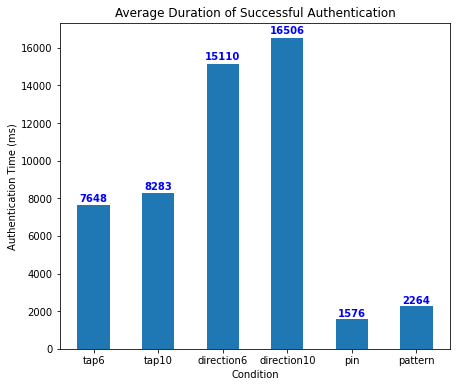

In [48]:
def computeAverageSuccessTime(lst):
    successfulAuths = list(filter(lambda x: x['endState'] == 'SUCCESS', lst))
    total = 0
    for val in lst:
        total += val['elapsedTimeInMilliseconds']
    return total/len(successfulAuths)


successRates = {}
for method in methodsDict:
    successRates[method] = computeAverageSuccessTime(methodsDict[method])

fig, ax = plt.subplots(figsize=(7, 6))
ax.set_ylabel('Authentication Time (ms)')
ax.set_xlabel('Condition')
ax.set_title('Average Duration of Successful Authentication')

x = list(successRates.keys())
y = list(successRates.values())
rects = ax.bar(x, y, 0.5)

for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.01*height, '%d' %
            round(height),  ha='center', va='bottom', color='blue', fontweight='bold')


### Time Distribution


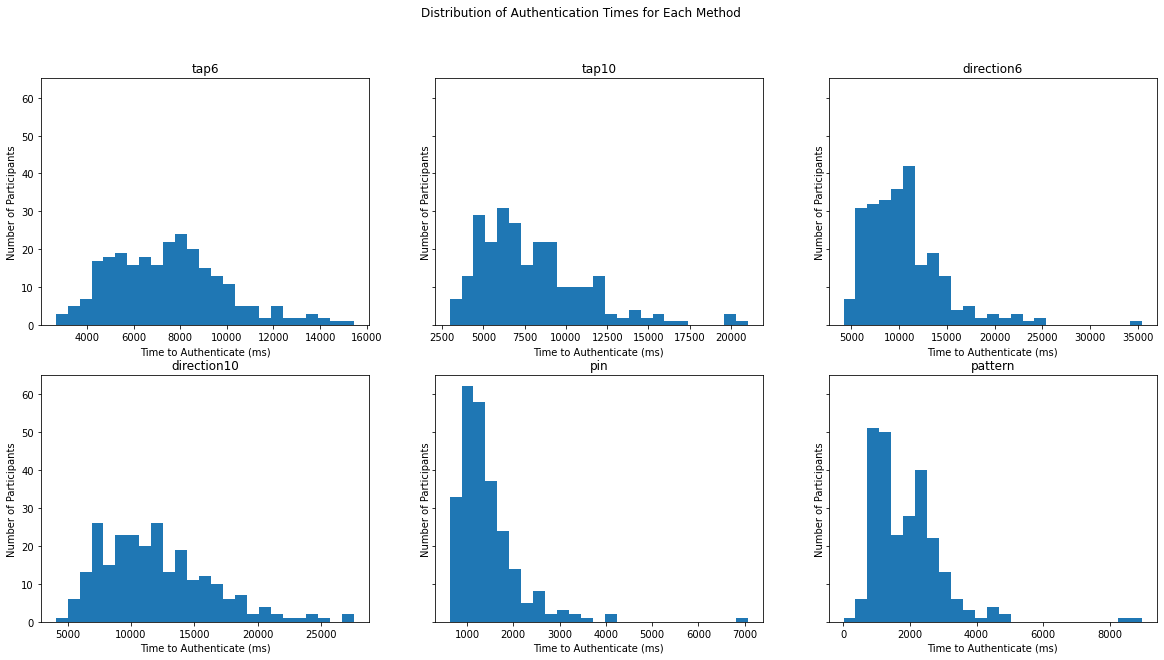

In [49]:
successfulAuths = methodsDict.copy()

for item in successfulAuths:
    successfulAuths[item] = list(
        filter(lambda x: x['endState'] == 'SUCCESS', successfulAuths[item]))
successfulAuthsTimeList = list(map(lambda x: {x: list(map(
    lambda y: y['elapsedTimeInMilliseconds'], successfulAuths[x]))}, successfulAuths))

fig, axs = plt.subplots(2, 3, sharey=True, figsize=(20, 10))
fig.suptitle('Distribution of Authentication Times for Each Method')

n_bins = 25


for i in range(0, 2):
    for j in range(0, 3):
        axs[i, j].hist(successfulAuthsTimeList[3*i+j].values(), bins=n_bins)
        axs[i, j].set_title(list(successfulAuthsTimeList[3*i+j].keys())[0])
        axs[i, j].set_xlabel('Time to Authenticate (ms)')
        axs[i, j].set_ylabel('Number of Participants')


### Statistical Tests - Repeated Measures One-Way ANOVA


In [50]:
# Parses files and puts data in a format for statistical tests

def getMethod(auth):
    if auth['method'] == 'tap':
        if auth['numTicks'] == '6':
            return 'tap6'
        else:
            return 'tap10'
    elif auth['method'] == 'direction':
        if auth['numTicks'] == '6':
            return 'direction6'
        else:
            return 'direction10'
    elif auth['method'] == 'PATTERN':
        return 'pattern'
    elif auth['method'] == 'PIN':
        return 'PIN'


def fileToTable(i, f, end=None):
    totalRows = []
    for key in f:
        for auth in f[key]:
            if auth['endState'] != 'ABORTED':
                if end == None:
                    totalRows.append(
                        [i, getMethod(auth), auth['elapsedTimeInMilliseconds'], auth['endState'], 'null'])
                elif auth['endState'] == end:
                    totalRows.append(
                        [i, getMethod(auth), auth['elapsedTimeInMilliseconds'], auth['endState'], 'null'])

    return totalRows


def createFileTable(end=None):
    fileTable = [['participant', 'method',
                  'elapsedTimeInMilliseconds', 'endState', 'errors']]
    for index, file in enumerate(files):
        fileTable += fileToTable(index, file, end)
    return fileTable


totalFileTable = createFileTable()
successFileTable = createFileTable(end='SUCCESS')
failureFileTable = createFileTable(end='FAILURE')


def createTempFileFromTable(fileName, table):
    with open(fileName, 'w') as f:
        for line in table:
            f.write(','.join([str(line[0]), line[1], str(
                line[2]), str(line[3]), str(line[4]), '\n']))


def mean(lst):
    return sum(lst)/len(lst)


createTempFileFromTable('successTemp.csv', successFileTable)
createTempFileFromTable('failureTemp.csv', failureFileTable)
createTempFileFromTable('totalTemp.csv', totalFileTable)

df = pd.read_csv('successTemp.csv')
print('REPEATED MEASURES ANOVA ON SUCCESS RATE:\n')
print(AnovaRM(df, 'elapsedTimeInMilliseconds', 'participant',
      within=['method'], aggregate_func=mean).fit())


def createErrorsFile():
    with open('errors.csv', 'w') as f:
        f.write('participant', 'method', 'errors')


# meanErrorRatesFromFile('failureTemp.csv')


REPEATED MEASURES ANOVA ON SUCCESS RATE:

                Anova
       F Value  Num DF  Den DF Pr > F
-------------------------------------
method 100.9817 5.0000 65.0000 0.0000



# User Perception


<BarContainer object of 6 artists>

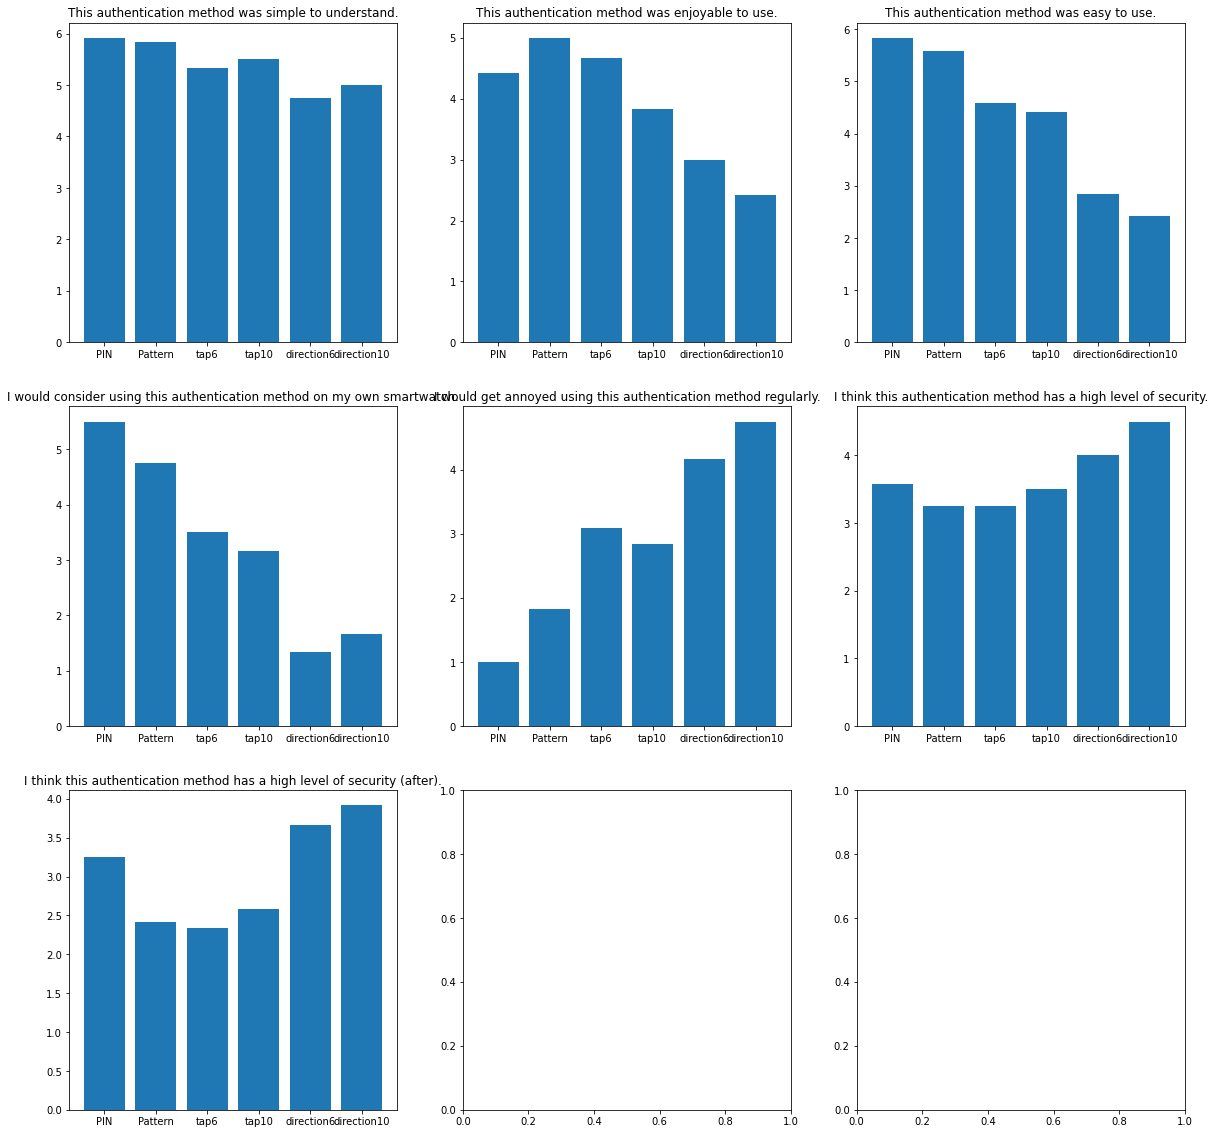

In [51]:

perception_dict = [{'Combination - Tap - 6': [], 'Combination - Tap - 10':[], 'Combination - Direction - 6':[], 'Combination - Direction - 10':[], 'PIN':[], 'Pattern':[]}, 
                   {'Combination - Tap - 6': [], 'Combination - Tap - 10':[], 'Combination - Direction - 6':[], 'Combination - Direction - 10':[], 'PIN':[], 'Pattern':[]},
                   {'Combination - Tap - 6': [], 'Combination - Tap - 10':[], 'Combination - Direction - 6':[], 'Combination - Direction - 10':[], 'PIN':[], 'Pattern':[]},
                   {'Combination - Tap - 6': [], 'Combination - Tap - 10':[], 'Combination - Direction - 6':[], 'Combination - Direction - 10':[], 'PIN':[], 'Pattern':[]},
                   {'Combination - Tap - 6': [], 'Combination - Tap - 10':[], 'Combination - Direction - 6':[], 'Combination - Direction - 10':[], 'PIN':[], 'Pattern':[]},
                   {'Combination - Tap - 6': [], 'Combination - Tap - 10':[], 'Combination - Direction - 6':[], 'Combination - Direction - 10':[], 'PIN':[], 'Pattern':[]},
                   {'Combination - Tap - 6': [], 'Combination - Tap - 10':[], 'Combination - Direction - 6':[], 'Combination - Direction - 10':[], 'PIN':[], 'Pattern':[]}]

with open('docs/user_perception.csv') as f:
    f.readline()
    for line in f:
        line = line.split(',')[1:]
        perception_dict[0][line[0]].append(int(line[1]))
        perception_dict[1][line[0]].append(int(line[2]))
        perception_dict[2][line[0]].append(int(line[3]))
        perception_dict[3][line[0]].append(int(line[4]))
        perception_dict[4][line[0]].append(int(line[5]))
        perception_dict[5][line[0]].append(int(line[6]))
        perception_dict[6][line[0]].append(int(line[8]))




for dic in perception_dict:
    for key in dic:
        dic[key] = mean(dic[key])
    
    dic['tap6'] = dic.pop('Combination - Tap - 6')
    dic['tap10'] = dic.pop('Combination - Tap - 10')
    dic['direction6'] = dic.pop('Combination - Direction - 6')
    dic['direction10'] = dic.pop('Combination - Direction - 10')


fig, axs = plt.subplots(3, 3, figsize=(20, 20))
axs[0, 0].set_title('This authentication method was simple to understand.')
axs[0, 0].bar(list(perception_dict[0].keys()),
              list(perception_dict[0].values()))
axs[0, 1].set_title('This authentication method was enjoyable to use.')
axs[0, 1].bar(list(perception_dict[1].keys()),
              list(perception_dict[1].values()))
axs[0, 2].set_title('This authentication method was easy to use.')
axs[0, 2].bar(list(perception_dict[2].keys()),
              list(perception_dict[2].values()))
axs[1, 0].set_title(
    'I would consider using this authentication method on my own smartwatch.')
axs[1, 0].bar(list(perception_dict[3].keys()),
              list(perception_dict[3].values()))
axs[1, 1].set_title(
    'I would get annoyed using this authentication method regularly.')
axs[1, 1].bar(list(perception_dict[4].keys()),
              list(perception_dict[4].values()))
axs[1, 2].set_title('I think this authentication method has a high level of security.')
axs[1, 2].bar(list(perception_dict[5].keys()),
              list(perception_dict[5].values()))
axs[2, 0].set_title(
    'I think this authentication method has a high level of security (after).')
axs[2, 0].bar(list(perception_dict[6].keys()),
              list(perception_dict[6].values()))

In [52]:
df = pd.read_csv('docs/user_perception.csv')
print('THIS AUTHENTICATION METHOD WAS SIMPLE TO UNDERSTAND:\n')
print(AnovaRM(df, 'This authentication method was simple to understand.',
      subject='ParticipantNumber', within=['method'], aggregate_func=mean).fit())
print('THIS AUTHENTICATION METHOD WAS ENJOYABLE TO USE:\n')
print(AnovaRM(df, 'This authentication method was enjoyable to use.',
      subject='ParticipantNumber', within=['method'], aggregate_func=mean).fit())
print('THIS AUTHENTICATION METHOD WAS EASY TO USE:\n')
print(AnovaRM(df, 'This authentication method was easy to use.',
      subject='ParticipantNumber', within=['method'], aggregate_func=mean).fit())
print('I WOULD CONSIDER USING THIS AUTHENTICATION METHOD ON MY OWN SMARTWATCH:\n')
print(AnovaRM(df, 'I would consider using this authentication method on my own smartwatch.',
      subject='ParticipantNumber', within=['method'], aggregate_func=mean).fit())
print('I WOULD GET ANNOYED USING THIS AUTHENTICATION METHOD REGULARLY:\n')
print(AnovaRM(df, 'I would get annoyed using this authentication method regularly.',
      subject='ParticipantNumber', within=['method'], aggregate_func=mean).fit())
print('I THINK THIS AUTHENTICATION METHOD HAS A HIGH LEVEL OF SECURITY:\n')
print(AnovaRM(df, 'I think this authentication method has a high level of security.',
      subject='ParticipantNumber', within=['method'], aggregate_func=mean).fit())
print('I THINK THIS AUTHENTICATION METHOD HAS A HIGH LEVEL OF SECURITY(AFTER):\n')
print(AnovaRM(df, 'I think this authentication method has a high level of security (after).',
      'ParticipantNumber', within=['method'], aggregate_func=mean).fit())


THIS AUTHENTICATION METHOD WAS SIMPLE TO UNDERSTAND:

               Anova
       F Value Num DF  Den DF Pr > F
------------------------------------
method  4.4669 5.0000 55.0000 0.0017

THIS AUTHENTICATION METHOD WAS ENJOYABLE TO USE:

               Anova
       F Value Num DF  Den DF Pr > F
------------------------------------
method  8.2369 5.0000 55.0000 0.0000

THIS AUTHENTICATION METHOD WAS EASY TO USE:

               Anova
       F Value Num DF  Den DF Pr > F
------------------------------------
method 19.4107 5.0000 55.0000 0.0000

I WOULD CONSIDER USING THIS AUTHENTICATION METHOD ON MY OWN SMARTWATCH:

               Anova
       F Value Num DF  Den DF Pr > F
------------------------------------
method 14.2424 5.0000 55.0000 0.0000

I WOULD GET ANNOYED USING THIS AUTHENTICATION METHOD REGULARLY:

               Anova
       F Value Num DF  Den DF Pr > F
------------------------------------
method 12.1223 5.0000 55.0000 0.0000

I THINK THIS AUTHENTICATION METHOD HAS A HIGH LE